In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

%config InlineBackend.figure_format='retina'

In [2]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.7.0
	• tf.keras version: 2.7.0
	• GPU device not found. Running on CPU


# 1. Load the dataset

In [3]:
# Combine the train and test dataset and then split the dataset for train, validation and test
splits = ['train[:60%]+test[:60%]', 'train[60%:80%]+test[60%:80%]', 'train[80%:]+test[80%:]']

dataset, dataset_info = tfds.load('fashion_mnist', split=splits, as_supervised=True, with_info=True)

training_set, validation_set, test_set = dataset

print('Dataset has type:', type(dataset))
print('Dataset has {:,} elements'.format(len(dataset)))

Dataset has type: <class 'list'>
Dataset has 3 elements


In [4]:
print('Training set has {:,} elements'.format(len(training_set)))
print('Validation set has {:,} elements'.format(len(validation_set)))
print('Test set has {:,} elements'.format(len(test_set)))

Training set has 42,000 elements
Validation set has 14,000 elements
Test set has 14,000 elements


In [5]:
# Display the information of dataset
dataset_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='C:\\Users\\sanka\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han

# 2. Explore the dataset

In [6]:
# Display the total images in the train, validation and test set
train_split = 60
test_val_split = 20

total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = (total_examples * train_split)//100
num_validation_examples = (total_examples * test_val_split)//100
num_test_examples = num_validation_examples

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

There are 42,000 images in the training set
There are 14,000 images in the validation set
There are 14,000 images in the test set


In [7]:
# Create label names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [8]:
# Display the type and the shape of one image
for image, label in training_set.take(1):
    print('The images in the training set have:\n\u2022 dtype:', image.dtype, '\n\u2022 shape:', image.shape)

The images in the training set have:
• dtype: <dtype: 'uint8'> 
• shape: (28, 28, 1)


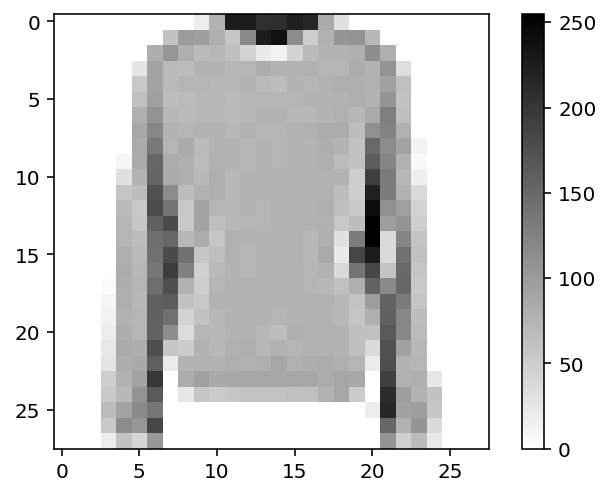

The label of this image is: 2
The class name of this image is: Pullover


In [9]:
# Plot one image
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names[label])

# 3. Create Pipeline

In [10]:
def normalize(image, label):
    """Normalize the pixel image from (0 - 255) to (0 - 1)"""
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size=64

training_batches = training_set.shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.batch(batch_size).map(normalize).prefetch(1)

# 4. Build the Model

In [11]:
# Specify architecture
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
])

In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 5. Evaluate Loss and Accuracy on the Test set before training the model

In [13]:
loss, accuracy = model.evaluate(testing_batches)
print('\nLoss on the Test set: {:,.3f}'.format(loss))
print('Accuracy on the Test set: {:,.3f}'.format(accuracy))

219/219 [==============================] - 1s 1ms/step - loss: 2.3000 - accuracy: 0.1313

Loss on the Test set: 2.300
Accuracy on the Test set: 0.131


# 6. Train the Model with the Validation Set

In [14]:
EPOCHS = 30

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/30
657/657 [==============================] - 2s 2ms/step - loss: 0.5381 - accuracy: 0.8075 - val_loss: 0.4304 - val_accuracy: 0.8481
Epoch 2/30
657/657 [==============================] - 1s 2ms/step - loss: 0.3879 - accuracy: 0.8591 - val_loss: 0.4019 - val_accuracy: 0.8582
Epoch 3/30
657/657 [==============================] - 1s 2ms/step - loss: 0.3486 - accuracy: 0.8718 - val_loss: 0.3800 - val_accuracy: 0.8634
Epoch 4/30
657/657 [==============================] - 1s 2ms/step - loss: 0.3260 - accuracy: 0.8796 - val_loss: 0.3554 - val_accuracy: 0.8707
Epoch 5/30
657/657 [==============================] - 1s 2ms/step - loss: 0.3084 - accuracy: 0.8857 - val_loss: 0.3430 - val_accuracy: 0.8764
Epoch 6/30
657/657 [==============================] - 1s 2ms/step - loss: 0.2919 - accuracy: 0.8921 - val_loss: 0.3405 - val_accuracy: 0.8837
Epoch 7/30
657/657 [==============================] - 1s 2ms/step - loss: 0.2763 - accuracy: 0.8964 - val_loss: 0.3522 - val_accuracy: 0.8804
Epoch 

## Loss and Validation Plots after training the model

In [15]:
print('history.history has type:', type(history.history))
print('\nThe keys of history.history are:', list(history.history.keys()))

history.history has type: <class 'dict'>

The keys of history.history are: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


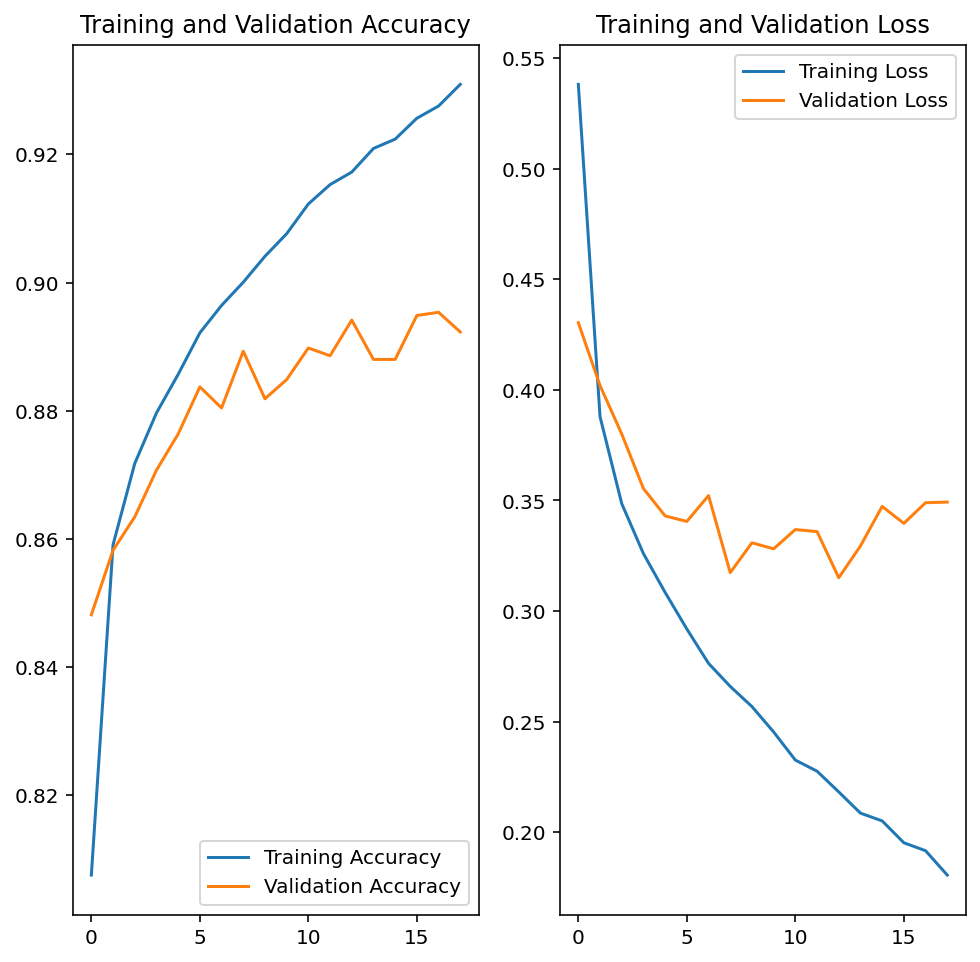

In [16]:
# Plot the training and validation accuracy and loss
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(len(training_accuracy))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show();

# 7. Inference

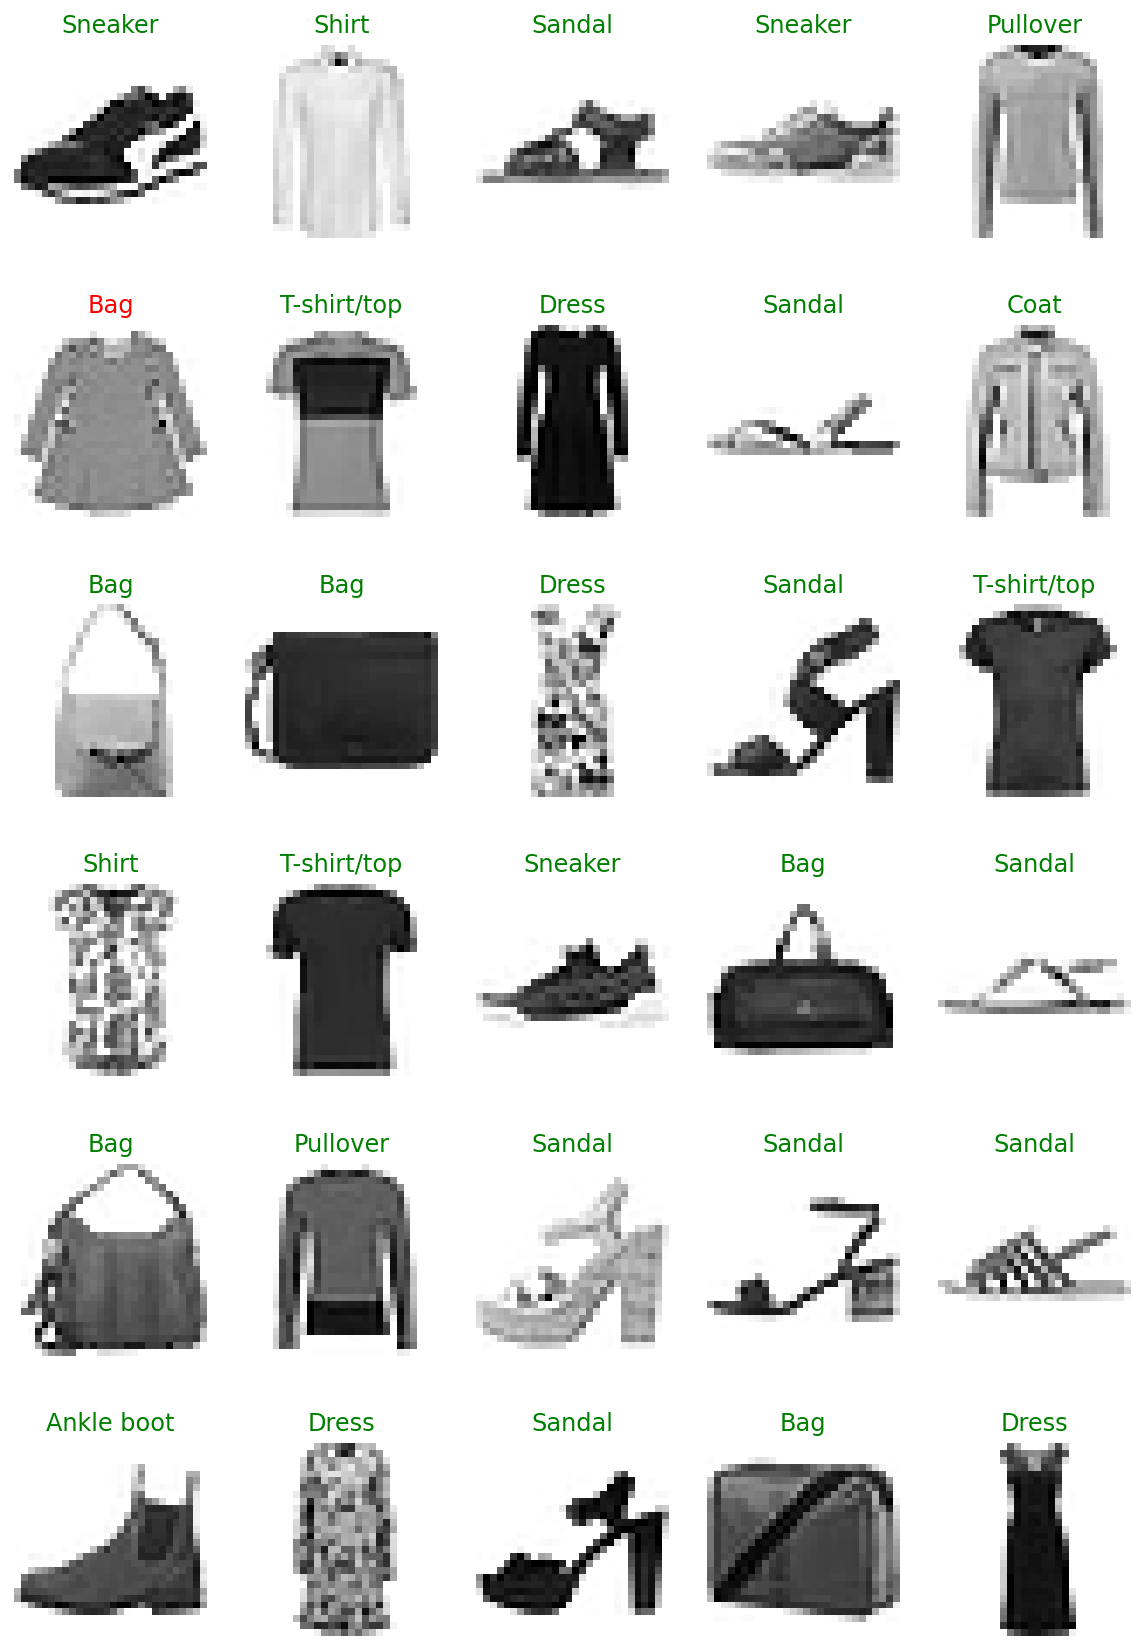

In [17]:
# Predict 30 images
for image_batch, label_batch in testing_batches.take(1):
    probs = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()
    
plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap=plt.cm.binary)
    color='green' if np.argmax(probs[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(probs[n])], color=color)
    plt.axis('off')
    
plt.show();             